In [1014]:
import sklearn.tree
import graphviz
import pandas as pd
pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [228]:
# ! pip install graphviz

In [229]:
df = pd.read_csv('bank-full.csv', sep = ';')
df = df.drop(['duration', 'campaign'], axis = 1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,-1,0,unknown,no


In [230]:
for p in ['default', 'housing', 'loan', 'y']:
    df[p] = df[p].map(lambda x: 1 if x == 'yes' else 0)

In [231]:
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

df['month'] = df.month.map(lambda x: month_map[x] if x in month_map else x)

In [232]:
df['id'] = list(range(df.shape[0]))

In [233]:
fin_df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'poutcome', 'contact'], dtype = int, 
              drop_first = False)

In [234]:
fin_df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [235]:
fin_df.head()

,age,default,balance,housing,loan,day,month,pdays,previous,y,...,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,contact_cellular,contact_telephone,contact_unknown
0,58,0,2143,1,0,5,5,-1,0,0,...,0,1,0,0,0,0,1,0,0,1
1,44,0,29,1,0,5,5,-1,0,0,...,1,0,0,0,0,0,1,0,0,1
2,33,0,2,1,1,5,5,-1,0,0,...,1,0,0,0,0,0,1,0,0,1
3,47,0,1506,1,0,5,5,-1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,33,0,1,0,0,5,5,-1,0,0,...,0,0,1,0,0,0,1,0,0,1


In [236]:
fin_df.merge(df[['id', 'poutcome']])\
    .groupby(['poutcome', 'poutcome_unknown', 'poutcome_failure', 'poutcome_other', 'poutcome_success'], as_index = False).y.count()\
    .rename(columns = {'y': 'cases'})\
    .sort_values('cases', ascending = False)

,poutcome,poutcome_unknown,poutcome_failure,poutcome_other,poutcome_success,cases
3,unknown,1,0,0,0,36959
0,failure,0,1,0,0,4901
1,other,0,0,1,0,1840
2,success,0,0,0,1,1511


In [237]:
fin_df = fin_df.drop('id', axis = 1)

In [238]:
feature_names = fin_df.drop(['y'], axis = 1).columns
len(feature_names)

35

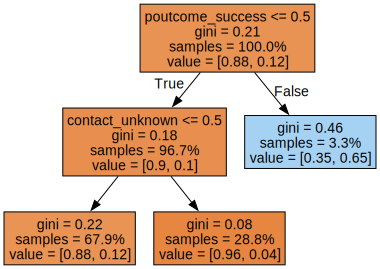

In [239]:
model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 1000, max_depth = 2)
model.fit(fin_df[feature_names], fin_df['y'])

dot_data = sklearn.tree.export_graphviz(
    model, out_file=None, feature_names = feature_names, filled = True, 
    proportion = True, precision=2, impurity = True)

graph = graphviz.Source(dot_data)
graph

In [240]:
fin_df.head().T

,0,1,2,3,4
age,58,44,33,47,33
default,0,0,0,0,0
balance,2143,29,2,1506,1
housing,1,1,1,1,0
loan,0,0,1,0,0
day,5,5,5,5,5
month,5,5,5,5,5
pdays,-1,-1,-1,-1,-1
previous,0,0,0,0,0
y,0,0,0,0,0


In [241]:
def get_gini(df):
    p = df.y.mean()
    return 2*p*(1-p)

In [242]:
get_gini(fin_df)

0.2065987201592864

In [243]:
def get_gini_comb(df1, df2):
    n1 = df1.shape[0]
    n2 = df2.shape[0]

    gini1 = get_gini(df1)
    gini2 = get_gini(df2)
    return (gini1*n1 + gini2*n2)/(n1 + n2) 

In [244]:
import tqdm
def optimise_one_parameter(df, param):
    tmp = []
    possible_values = list(sorted(df[param].unique()))
    print(param)
    for i in tqdm.tqdm(range(1, len(possible_values))): 
        threshold = (possible_values[i-1] + possible_values[i])/2
        gini = get_gini_comb(df[df[param] <= threshold], df[df[param] > threshold])
        tmp.append(
            {'param': param, 'threshold': threshold, 'gini': gini, 
            'sizes': (df[df[param] <= threshold].shape[0], df[df[param] > threshold].shape[0])}
        )
    return pd.DataFrame(tmp)

In [245]:
tmp_dfs = []
for feature in feature_names:
    tmp_dfs.append(optimise_one_parameter(fin_df, feature))

age


100%|██████████████████████████████████████████| 76/76 [00:00<00:00, 249.91it/s]


default


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 263.78it/s]


balance


100%|██████████████████████████████████████| 7167/7167 [00:24<00:00, 293.59it/s]


housing


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 220.51it/s]


loan


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 257.32it/s]


day


100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 335.82it/s]


month


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 284.72it/s]


pdays


100%|████████████████████████████████████████| 558/558 [00:02<00:00, 211.82it/s]


previous


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 265.73it/s]


job_admin.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 244.15it/s]


job_blue-collar


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 235.69it/s]


job_entrepreneur


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 141.60it/s]


job_housemaid


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 182.12it/s]


job_management


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 210.40it/s]


job_retired


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 203.71it/s]


job_self-employed


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 196.00it/s]


job_services


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 210.43it/s]


job_student


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 165.53it/s]


job_technician


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 193.61it/s]


job_unemployed


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 181.68it/s]


job_unknown


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.74it/s]


marital_divorced


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 188.92it/s]


marital_married


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 193.24it/s]


marital_single


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 223.71it/s]


education_primary


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 237.92it/s]


education_secondary


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 214.00it/s]


education_tertiary


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 243.26it/s]


education_unknown


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 216.50it/s]


poutcome_failure


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 164.33it/s]


poutcome_other


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 185.81it/s]


poutcome_success


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 223.36it/s]


poutcome_unknown


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 201.85it/s]


contact_cellular


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 205.09it/s]


contact_telephone


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 165.95it/s]


contact_unknown


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 205.51it/s]


In [246]:
opt_df = pd.concat(tmp_dfs)

In [247]:
opt_df.sort_values('gini', ascending = True).head()

,param,threshold,gini,sizes
0,poutcome_success,0.50,0.19,"(43700, 1511)"
8,pdays,8.50,0.20,"(37062, 8149)"
9,pdays,9.50,0.20,"(37074, 8137)"
11,pdays,12.50,0.20,"(37087, 8124)"
17,pdays,19.50,0.20,"(37112, 8099)"


In [248]:
tmp_dfs = []
for feature in feature_names:
    tmp_dfs.append(optimise_one_parameter(
      fin_df[fin_df.poutcome_success <= 0.5], feature))
opt_df = pd.concat(tmp_dfs)

age


100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 259.79it/s]


default


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 189.03it/s]


balance


100%|██████████████████████████████████████| 7167/7167 [00:25<00:00, 277.36it/s]


housing


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 227.37it/s]


loan


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 195.31it/s]


day


100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 258.23it/s]


month


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 236.45it/s]


pdays


100%|████████████████████████████████████████| 533/533 [00:02<00:00, 259.55it/s]


previous


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 225.57it/s]


job_admin.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 212.32it/s]


job_blue-collar


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 228.73it/s]


job_entrepreneur


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 229.21it/s]


job_housemaid


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 212.09it/s]


job_management


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 220.50it/s]


job_retired


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 240.38it/s]


job_self-employed


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 227.57it/s]


job_services


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 220.80it/s]


job_student


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 192.89it/s]


job_technician


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 206.79it/s]


job_unemployed


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 202.71it/s]


job_unknown


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 237.70it/s]


marital_divorced


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 242.71it/s]


marital_married


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 201.86it/s]


marital_single


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 249.94it/s]


education_primary


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 201.61it/s]


education_secondary


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 237.30it/s]


education_tertiary


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 194.81it/s]


education_unknown


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 225.94it/s]


poutcome_failure


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 200.92it/s]


poutcome_other


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 184.61it/s]


poutcome_success


0it [00:00, ?it/s]


poutcome_unknown


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 218.53it/s]


contact_cellular


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 193.42it/s]


contact_telephone


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 213.78it/s]


contact_unknown


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 266.31it/s]


In [249]:
opt_df.sort_values('gini', ascending = True).head(5)

,param,threshold,gini,sizes
42,age,60.50,0.17,"(42711, 989)"
43,age,61.50,0.17,"(42830, 870)"
0,contact_unknown,0.50,0.17,"(30692, 13008)"
44,age,62.50,0.18,"(42892, 808)"
45,age,63.50,0.18,"(42957, 743)"


In [250]:
model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 1000, min_impurity_decrease=0.001)
model.fit(fin_df[feature_names], fin_df['y'])

dot_data = sklearn.tree.export_graphviz(
    model, out_file=None, feature_names = feature_names, filled = True, 
    proportion = True, precision=2, impurity = True)

graph = graphviz.Source(dot_data)

png_bytes = graph.pipe(format='png')
with open('decision_tree.png','wb') as f:
    f.write(png_bytes)

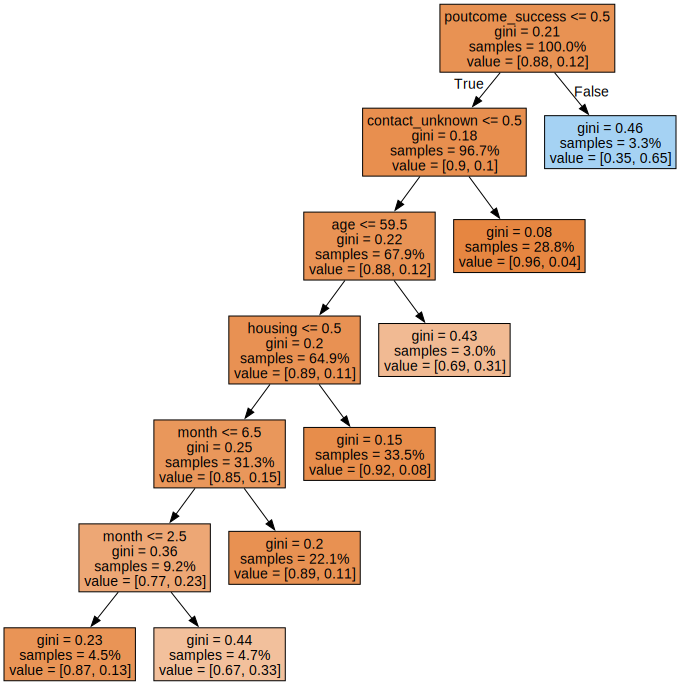

In [251]:
graph

In [252]:
n_nodes = model.tree_.node_count
n_nodes

13

In [253]:
children_left = model.tree_.children_left
children_right = model.tree_.children_right
children_left, children_right

(array([ 1,  2,  3,  4,  5,  6, -1, -1, -1, -1, -1, -1, -1], dtype=int64),
 array([12, 11, 10,  9,  8,  7, -1, -1, -1, -1, -1, -1, -1], dtype=int64))

In [254]:
features = model.tree_.feature
features

array([30, 34,  0,  3,  6,  6, -2, -2, -2, -2, -2, -2, -2], dtype=int64)

In [255]:
thresholds = model.tree_.threshold
thresholds

array([ 0.5,  0.5, 59.5,  0.5,  6.5,  2.5, -2. , -2. , -2. , -2. , -2. ,
       -2. , -2. ])

In [256]:
values = model.tree_.value
values

array([[[0.8830152 , 0.1169848 ]],

       [[0.90135011, 0.09864989]],

       [[0.87671054, 0.12328946]],

       [[0.88550191, 0.11449809]],

       [[0.8530886 , 0.1469114 ]],

       [[0.76686675, 0.23313325]],

       [[0.87043351, 0.12956649]],

       [[0.66619318, 0.33380682]],

       [[0.889     , 0.111     ]],

       [[0.91578184, 0.08421816]],

       [[0.68768328, 0.31231672]],

       [[0.95948647, 0.04051353]],

       [[0.35274653, 0.64725347]]])

In [257]:
num_nodes = model.tree_.n_node_samples
num_nodes

array([45211, 43700, 30692, 29328, 14165,  4165,  2053,  2112, 10000,
       15163,  1364, 13008,  1511], dtype=int64)

In [258]:
hierarchy = {}

for node_id in range(n_nodes):
    # print(node_id, '->', children_left[node_id], children_right[node_id])
    if children_left[node_id] != -1:
        hierarchy[children_left[node_id]] = {'parent': node_id, 'condition': 'left'}
    if children_right[node_id] != -1:
        hierarchy[children_right[node_id]] = {'parent': node_id, 'condition': 'right'}

In [259]:
hierarchy

{1: {'parent': 0, 'condition': 'left'},
 12: {'parent': 0, 'condition': 'right'},
 2: {'parent': 1, 'condition': 'left'},
 11: {'parent': 1, 'condition': 'right'},
 3: {'parent': 2, 'condition': 'left'},
 10: {'parent': 2, 'condition': 'right'},
 4: {'parent': 3, 'condition': 'left'},
 9: {'parent': 3, 'condition': 'right'},
 5: {'parent': 4, 'condition': 'left'},
 8: {'parent': 4, 'condition': 'right'},
 6: {'parent': 5, 'condition': 'left'},
 7: {'parent': 5, 'condition': 'right'}}

In [260]:
leaves = []
for node_id in range(n_nodes):
    if (children_left[node_id] == -1) and (children_right[node_id] == -1):
        leaves.append(node_id)

In [261]:
leaves

[6, 7, 8, 9, 10, 11, 12]

In [262]:
leaves_df = pd.DataFrame({'node_id': leaves})
leaves_df

,node_id
0,6
1,7
2,8
3,9
4,10
5,11
6,12


In [452]:
def get_condition(node_id, condition, features, thresholds, feature_names):
    # print(node_id, condition)
    feature = feature_names[features[node_id]]
    threshold = thresholds[node_id]
    cond = '>' if condition == 'right'  else '<='
    return (feature, cond, threshold)

In [454]:
get_condition(0, 'left', features, thresholds, feature_names)

('poutcome_success', '<=', 0.5)

In [455]:
get_condition(0, 'right', features, thresholds, feature_names)

('poutcome_success', '>', 0.5)

In [456]:
def get_decision_path_rec(node_id, decision_path, hierarchy):
    if node_id == 0:
        yield decision_path 
    else:
        parent_id = hierarchy[node_id]['parent']
        condition = hierarchy[node_id]['condition']
        for res in get_decision_path_rec(parent_id, decision_path + [(parent_id, condition)], hierarchy):
            yield res

decision_path = list(get_decision_path_rec(12, [], hierarchy))[0]
print(decision_path) 
fmt_decision_path = list(map(lambda x: get_condition(x[0], x[1], features, thresholds, feature_names), decision_path))
print(fmt_decision_path)

[(0, 'right')]
[('poutcome_success', '>', 0.5)]


In [463]:
def get_decision_path(node_id, features, thresholds, hierarchy, feature_names):
  decision_path = list(get_decision_path_rec(node_id, [], hierarchy))[0]
  return list(map(lambda x: get_condition(x[0], x[1], features, thresholds, feature_names), decision_path))

In [464]:
def get_decision_path_string(node_id, features, thresholds, hierarchy, feature_names):
  conditions_df = pd.DataFrame(get_decision_path(node_id, features, thresholds, hierarchy, feature_names))
  conditions_df.columns = ['feature', 'condition', 'threshold']

  left_conditions_df = conditions_df[conditions_df.condition == '<=']
  right_conditions_df = conditions_df[conditions_df.condition == '>']

  # deduplication 
  left_conditions_df = left_conditions_df.groupby(['feature', 'condition'], as_index = False).min()
  right_conditions_df = right_conditions_df.groupby(['feature', 'condition'], as_index = False).max()
  
  # concatination
  fin_conditions_df = pd.concat([left_conditions_df, right_conditions_df])\
      .sort_values(['feature', 'condition'], ascending = False)
  # formatting 
  fin_conditions_df['cond_string'] = list(map(
      lambda x, y, z: '(%s %s %.2f)' % (x, y, z),
      fin_conditions_df.feature,
      fin_conditions_df.condition,
      fin_conditions_df.threshold
  ))
  return ' and '.join(fin_conditions_df.cond_string.values)

In [465]:
get_decision_path_string(12, features, thresholds, hierarchy, feature_names)

'(poutcome_success > 0.50)'

In [467]:
leaves_df['condition'] = leaves_df['node_id'].map(
  lambda x: get_decision_path_string(x, features, thresholds, hierarchy, feature_names)
)

In [468]:
leaves_df

,node_id,condition,total,conversion,converted_users,share_of_converted,share_of_total
0,6,(poutcome_success <= 0.50) and (month <= 2.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),2053,12.96,266,5.03,4.54
1,7,(poutcome_success <= 0.50) and (month > 2.50) and (month <= 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),2112,33.38,705,13.33,4.67
2,8,(poutcome_success <= 0.50) and (month > 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),10000,11.10,1110,20.99,22.12
3,9,(poutcome_success <= 0.50) and (housing > 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),15163,8.42,1277,24.14,33.54
4,10,(poutcome_success <= 0.50) and (contact_unknown <= 0.50) and (age > 59.50),1364,31.23,426,8.05,3.02
5,11,(poutcome_success <= 0.50) and (contact_unknown > 0.50),13008,4.05,527,9.96,28.77
6,12,(poutcome_success > 0.50),1511,64.73,978,18.49,3.34


In [469]:
leaves_df['total'] = leaves_df.node_id.map(lambda x: num_nodes[x])
leaves_df['conversion'] = leaves_df['node_id'].map(lambda x: values[x][0][1])*100
leaves_df['converted_users'] = (leaves_df.conversion * leaves_df.total).map(lambda x: int(round(x/100)))
leaves_df['share_of_converted'] = 100*leaves_df['converted_users']/leaves_df['converted_users'].sum()
leaves_df['share_of_total'] = 100*leaves_df['total']/leaves_df['total'].sum()

In [470]:
leaves_df.sort_values('conversion', ascending = False).drop('node_id', axis = 1).set_index('condition')

,total,conversion,converted_users,share_of_converted,share_of_total
condition,,,,,
(poutcome_success > 0.50),1511,64.73,978,18.49,3.34
(poutcome_success <= 0.50) and (month > 2.50) and (month <= 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),2112,33.38,705,13.33,4.67
(poutcome_success <= 0.50) and (contact_unknown <= 0.50) and (age > 59.50),1364,31.23,426,8.05,3.02
(poutcome_success <= 0.50) and (month <= 2.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),2053,12.96,266,5.03,4.54
(poutcome_success <= 0.50) and (month > 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),10000,11.10,1110,20.99,22.12
(poutcome_success <= 0.50) and (housing > 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),15163,8.42,1277,24.14,33.54
(poutcome_success <= 0.50) and (contact_unknown > 0.50),13008,4.05,527,9.96,28.77


In [471]:
18.49 + 13.33 + 8.05

39.870000000000005

In [711]:
# https://en.wikipedia.org/wiki/List_of_primary_urban_areas_in_England_by_population
eng_cities_df = pd.read_csv('gb.csv', sep = '\t')[['Primary urban area', 'Population']]
eng_cities_df.columns = ['region', 'population']

In [712]:
eng_cities_df.head(10)

,region,population
0,London,"8,294,058"
1,Birmingham,"2,293,099"
2,Manchester,"1,741,961"
3,Liverpool,"830,112"
4,Leeds,"750,700"
5,Sheffield,"551,800"
6,Teesside,"472,200"
7,Bristol,"428,234"
8,Bournemouth and Poole,"382,536"
9,Stoke-on-Trent,"360,810"


In [713]:
eng_cities_df['population'] = eng_cities_df.population.map(lambda x: int(x.replace(',', '')))

In [714]:
eng_cities_df['base_weight'] = eng_cities_df.population/eng_cities_df.population.sum()

In [715]:
eng_cities_df['population_tweak'] = list(map(
    lambda x, y: x if y not in ('Manchester', 'Liverpool', 'Bristol', 'Newcastle', 'Leicester')  else 10*x,
    eng_cities_df.population,
    eng_cities_df.region
))

In [716]:
eng_cities_df['tweak_weight'] = eng_cities_df.population_tweak/eng_cities_df.population_tweak.sum()

In [717]:
outliers = ["Aberfeldy", "Aberlour", "Aboyne", "Acharacle", "Achnasheen", "Airdrie", "Alford", "Alloa", "Alness", "Annan", 
             "Anstruther", "Arbroath", "Ardrossan", "Arisaig", "Armadale", "Auchterarder", "Aviemore", "Ballachulish", "Ballater",
             "Balmaha", "Banff", "Bathgate", "Beauly", "Biggar", "Blairgowrie", "Boat of Garten", "Bonar Bridge", "Bonnyrigg", 
             "Braemar", "Brora", "Buckie", "Callander", "Campbeltown", "Carluke", "Carnoustie", "Castle Douglas", "Castlebay", 
             "Ceres", "Crail", "Crieff", "Cromarty", "Cullen", "Culross", "Dalbeattie", "Dalmally", "Dalry", "Dingwall", "Dollar", 
             "Doune", "Drumnadrochit", "Dunbar", "Dunblane", "Dornoch", "Dunoon", "Duns", "East Linton", "Elgin", "Ellon", "Eyemouth", 
             "Falkland", "Forres", "Fort Augustus", "Fortrose", "Fraserburgh", "Galashiels", "Gatehouse of Fleet", "Girvan", "Golspie",
             "Grantown-on-Spey", "Haddington", "Hawick", "Helensburgh", "Huntly", "Inveraray", "Invergordon", "Inverkeithing", "Inverurie", 
             "Jedburgh", "Keith", "Kelso", "Kilwinning", "Kinghorn", "Kingussie", "Kinross", "Kirkcudbright", "Kirkwall", "Lairg", "Lanark", 
             "Langholm", "Largs", "Lerwick", "Linlithgow", "Lochgilphead", "Lossiemouth", "Mallaig", "Melrose", "Montrose", "Moffat", "Monifieth", 
             "Nairn", "Newburgh", "Newtonmore", "North Berwick"]

len(outliers)

103

In [718]:
eng_cities_df = eng_cities_df[~eng_cities_df.region.isin(outliers)]

In [719]:
import random

In [725]:
def get_region(y):
    if random.random() <= 0.01:
        return random.choices(outliers)[0]
    if y == 1:
        return random.choices(eng_cities_df.region, weights=eng_cities_df['tweak_weight'])[0]
    else:
        return random.choices(eng_cities_df.region, weights=eng_cities_df['base_weight'])[0]
    

In [726]:
df['region'] = df.y.map(get_region)

In [727]:
df.region.value_counts(normalize = True).head(15)

region
London                  0.31
Manchester              0.09
Birmingham              0.08
Liverpool               0.05
Leeds                   0.03
Bristol                 0.02
Sheffield               0.02
Leicester               0.02
Teesside                0.02
Newcastle               0.02
Bournemouth and Poole   0.01
Stoke-on-Trent          0.01
Wirral                  0.01
Coventry                0.01
Nottingham              0.01
Name: proportion, dtype: float64

In [728]:
df.region.nunique()

155

In [729]:
fin_df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'poutcome', 'contact', 'region'], dtype = int, 
              drop_first = False)

In [730]:
fin_df.shape[1]

192

In [731]:
feature_names = fin_df.drop(['y', 'id'], axis = 1).columns
len(feature_names)

190

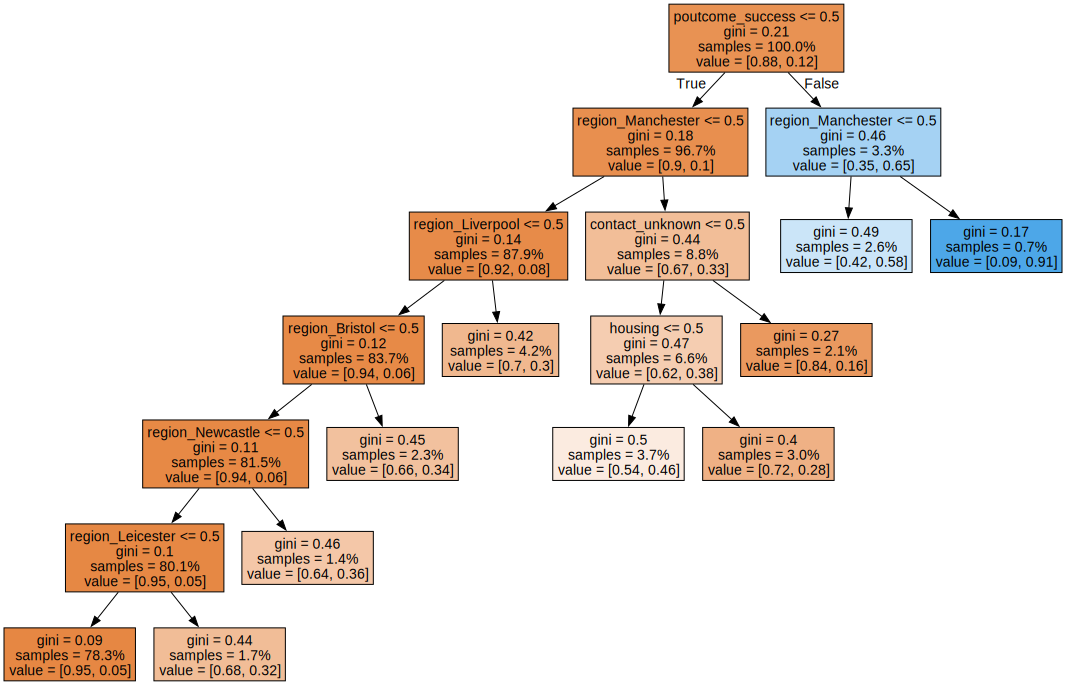

In [732]:
model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 100, min_impurity_decrease=0.001)
model.fit(fin_df[feature_names], fin_df['y'])

dot_data = sklearn.tree.export_graphviz(
    model, out_file=None, feature_names = feature_names, filled = True, 
    proportion = True, precision=2, impurity = True)

graph = graphviz.Source(dot_data)
png_bytes = graph.pipe(format='png')
with open('decision_tree.png','wb') as f:
    f.write(png_bytes)

graph

In [733]:
from sklearn.model_selection import train_test_split

In [734]:
fin_df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'poutcome', 'contact'], dtype = int, 
              drop_first = False)

In [735]:
train_df, test_df = train_test_split(fin_df,test_size=0.1, random_state=42)

In [736]:
train_df.shape[0], test_df.shape[0]

(40689, 4522)

In [737]:
def get_model_definition(model, feature_names):
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    features = model.tree_.feature
    thresholds = model.tree_.threshold
    num_nodes = model.tree_.n_node_samples
    values = model.tree_.value

    hierarchy = {}

    for node_id in range(n_nodes):
        if children_left[node_id] != -1: 
            hierarchy[children_left[node_id]] = {
              'parent': node_id, 
              'condition': 'left'
            }
      
        if children_right[node_id] != -1:
              hierarchy[children_right[node_id]] = {
               'parent': node_id, 
               'condition': 'right'
              }

    leaves = []
    for node_id in range(n_nodes):
        if (children_left[node_id] == -1) and (children_right[node_id] == -1):
            leaves.append(node_id)
    leaves_df = pd.DataFrame({'node_id': leaves})
    leaves_df['condition'] = leaves_df['node_id'].map(
      lambda x: get_decision_path_string(x, features, thresholds, hierarchy, feature_names)
    )

    leaves_df['total'] = leaves_df.node_id.map(lambda x: num_nodes[x])
    leaves_df['conversion'] = leaves_df['node_id'].map(lambda x: values[x][0][1])*100
    leaves_df['converted_users'] = (leaves_df.conversion * leaves_df.total).map(lambda x: int(round(x/100)))
    leaves_df['share_of_converted'] = 100*leaves_df['converted_users']/leaves_df['converted_users'].sum()
    leaves_df['share_of_total'] = 100*leaves_df['total']/leaves_df['total'].sum()
    leaves_df = leaves_df.sort_values('conversion', ascending = False)\
      .drop('node_id', axis = 1).set_index('condition')
    leaves_df['cum_share_of_total'] = leaves_df['share_of_total'].cumsum()
    leaves_df['cum_share_of_converted'] = leaves_df['share_of_converted'].cumsum()
    return leaves_df

In [738]:
train_df

,age,default,balance,housing,loan,day,month,pdays,previous,y,...,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,contact_cellular,contact_telephone,contact_unknown
14565,29,0,0,1,0,15,7,-1,0,0,...,0,0,0,0,0,0,1,1,0,0
20546,57,0,396,0,0,12,8,-1,0,0,...,1,0,0,0,0,0,1,1,0,0
34495,54,0,714,0,0,5,5,-1,0,0,...,0,0,0,0,0,0,1,1,0,0
13814,52,0,2072,0,0,10,7,-1,0,0,...,1,0,0,0,0,0,1,1,0,0
42153,34,0,1778,0,0,4,11,162,2,1,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,0,1059,0,0,18,6,-1,0,1,...,0,0,0,0,0,0,1,0,0,1
44732,23,0,508,0,0,8,9,92,1,0,...,0,1,0,1,0,0,0,1,0,0
38158,34,0,1317,1,0,15,5,-1,0,0,...,0,1,0,0,0,0,1,1,0,0
860,33,0,165,0,0,7,5,-1,0,0,...,1,0,0,0,0,0,1,0,0,1


In [739]:
region_encoding_df = train_df.groupby('region', as_index = False).aggregate({'id': 'count', 'y': 'mean'}).rename(columns = 
    {'id': 'region_count', 'y': 'region_target'})

In [740]:
train_df = train_df.merge(region_encoding_df, on = 'region')

In [741]:
count_feature_names = train_df.drop(['y', 'id', 'region_target', 'region'], axis = 1).columns
target_feature_names = train_df.drop(['y', 'id', 'region_count', 'region'], axis = 1).columns
len(count_feature_names), len(target_feature_names)

(36, 36)

In [742]:
count_feature_names

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'region_count'],
      dtype='object')

In [743]:
count_model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 500, min_impurity_decrease=0.001)
count_model.fit(train_df[count_feature_names], train_df['y'])

target_model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 500, min_impurity_decrease=0.001)
target_model.fit(train_df[target_feature_names], train_df['y'])

DecisionTreeClassifier(min_impurity_decrease=0.001, min_samples_leaf=500)

In [744]:
count_model_def_df = get_model_definition(count_model, count_feature_names)
target_model_def_df = get_model_definition(target_model, target_feature_names)

In [754]:
count_model_def_df.head(7)

,total,conversion,converted_users,share_of_converted,share_of_total,cum_share_of_total,cum_share_of_converted
condition,,,,,,,
(poutcome_success > 0.50),1353,64.67,875,18.48,3.33,3.33,18.48
(poutcome_success <= 0.50) and (age > 60.50),898,37.08,333,7.03,2.21,5.53,25.51
(region_count > 3645.50) and (region_count <= 8151.50) and (poutcome_success <= 0.50) and (contact_cellular > 0.50) and (age <= 60.50),2350,36.68,862,18.20,5.78,11.31,43.72
(region_count > 589.50) and (region_count <= 2630.00) and (poutcome_success <= 0.50) and (contact_unknown <= 0.50) and (age <= 60.50),4559,24.19,1103,23.29,11.20,22.51,67.01
(region_count > 3645.50) and (region_count <= 8151.50) and (poutcome_success <= 0.50) and (contact_cellular <= 0.50) and (age <= 60.50),1063,17.40,185,3.91,2.61,25.12,70.92
(region_count > 589.50) and (region_count <= 2630.00) and (poutcome_success <= 0.50) and (contact_unknown > 0.50) and (age <= 60.50),1795,8.69,156,3.29,4.41,29.54,74.21
(region_count > 8151.50) and (poutcome_success <= 0.50) and (age <= 60.50),11936,4.40,525,11.09,29.33,58.87,85.30


In [755]:
target_model_def_df.head(7)

,total,conversion,converted_users,share_of_converted,share_of_total,cum_share_of_total,cum_share_of_converted
condition,,,,,,,
(region_target > 0.21) and (poutcome_success > 0.50),634,90.54,574,12.12,1.56,1.56,12.12
(region_target > 0.21) and (poutcome_success <= 0.50) and (month <= 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50),1154,56.67,654,13.81,2.84,4.39,25.93
(region_target > 0.21) and (poutcome_success <= 0.50) and (month > 8.50) and (housing <= 0.50) and (contact_unknown <= 0.50),577,54.07,312,6.59,1.42,5.81,32.52
(region_target <= 0.21) and (poutcome_success > 0.50),719,41.86,301,6.36,1.77,7.58,38.88
(region_target > 0.21) and (poutcome_success <= 0.50) and (month > 6.50) and (month <= 8.50) and (housing <= 0.50) and (contact_unknown <= 0.50),1438,30.60,440,9.29,3.53,11.11,48.17
(region_target > 0.21) and (poutcome_success <= 0.50) and (housing > 0.50) and (contact_unknown <= 0.50),2528,30.14,762,16.09,6.21,17.33,64.27
(region_target > 0.21) and (poutcome_success <= 0.50) and (contact_unknown > 0.50),1867,14.73,275,5.81,4.59,21.92,70.07


In [747]:
test_df = test_df.merge(region_encoding_df)
total = test_df.shape[0]
converted = test_df.y.sum()
total, converted, converted/total*100

(4522, 554, 12.251216275984078)

In [756]:
count_selected_df = test_df[
    (test_df.poutcome_success > 0.50) | 
    ((test_df.poutcome_success <= 0.50) & (test_df.age > 60.50)) | 
    ((test_df.region_count > 3645.50) & (test_df.region_count <= 8151.50) & 
         (test_df.poutcome_success <= 0.50) & (test_df.contact_cellular > 0.50) & (test_df.age <= 60.50))
]

count_selected_df.shape[0], count_selected_df.y.sum()

(508, 227)

In [759]:
region_encoding_df[(region_encoding_df.region_count > 3645.50) & (region_encoding_df.region_count <= 8151.50)]

,region,region_count,region_target
119,Manchester,3857,0.37


In [758]:
target_selected_df = test_df[
    ((test_df.region_target > 0.21) & (test_df.poutcome_success > 0.50)) | 
    ((test_df.region_target > 0.21) & (test_df.poutcome_success <= 0.50) & (test_df.month <= 6.50) & (test_df.housing <= 0.50) & (test_df.contact_unknown <= 0.50)) | 
    ((test_df.region_target > 0.21) & (test_df.poutcome_success <= 0.50) & (test_df.month > 8.50) & (test_df.housing <= 0.50) 
         & (test_df.contact_unknown <= 0.50)) |
    ((test_df.region_target <= 0.21) & (test_df.poutcome_success > 0.50)) |
    ((test_df.region_target > 0.21) & (test_df.poutcome_success <= 0.50) & (test_df.month > 6.50) & (test_df.month <= 8.50) 
         & (test_df.housing <= 0.50) & (test_df.contact_unknown <= 0.50))
]

target_selected_df.shape[0], target_selected_df.y.sum()

(502, 248)

In [760]:
248 / 227 *100

109.2511013215859

In [761]:
region_encoding_df[region_encoding_df.region_target > 0.21].sort_values('region_count', ascending = False)

,region,region_count,region_target
119,Manchester,3857,0.37
113,Liverpool,1826,0.35
37,Bristol,995,0.38
110,Leicester,774,0.37
128,Newcastle,632,0.40
70,Ellon,9,0.22
67,Dunoon,8,0.50
118,Mallaig,7,0.43
44,Carluke,7,0.29
10,Annan,6,0.33


In [1036]:
from sklearn.preprocessing import TargetEncoder
enc_auto = TargetEncoder(smooth="auto", random_state=42, target_type='binary')

In [1037]:
train_df, test_df = train_test_split(fin_df,test_size=0.1, random_state=42)

In [1038]:
region_encoding_df = train_df.groupby('region', as_index = False).aggregate({'id': 'count', 'y': 'mean'}).rename(columns = 
    {'id': 'region_count', 'y': 'raw_region_target'})

In [1039]:
global_mean = train_df.y.mean()
global_count = train_df.shape[0]
global_mean, global_count

(0.11637051783037185, 40689)

In [1082]:
import numpy as np
k = 100
f = 10

k = 100
f = 100
region_encoding_df['smoothing'] = (1 / (1 + np.exp(-(region_encoding_df.region_count - k) / f)))

In [1083]:
smooth_df = pd.DataFrame({'region_count':np.arange(1, 100001, 1) })
smooth_df['smoothing'] = (1 / (1 + np.exp(-(smooth_df.region_count - k) / f)))

Text(0.5, 1.0, 'Smoothing: k = 100, f = 100')

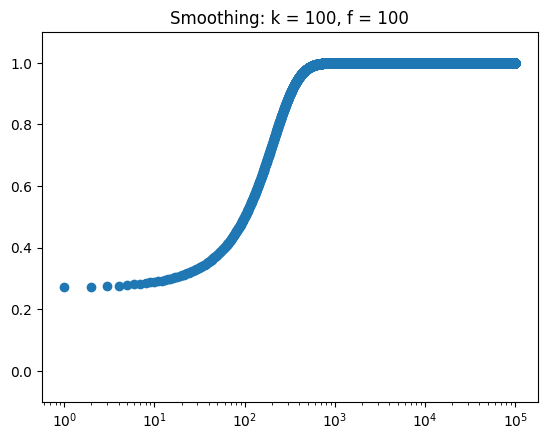

In [1084]:
import matplotlib.pyplot as plt

ax = plt.scatter(smooth_df.region_count, smooth_df.smoothing)
plt.xscale('log')
plt.ylim([-.1, 1.1])
plt.title('Smoothing: k = %d, f = %d' % (k, f))

In [1043]:
region_encoding_df['smoothing'] = (1 / (1 + np.exp(-(region_encoding_df.region_count - k) / f)))

In [1044]:
region_encoding_df['region_target'] = region_encoding_df.smoothing * region_encoding_df.raw_region_target \
    + (1 - region_encoding_df.smoothing) * global_mean

In [1045]:
region_encoding_df

,region,region_count,raw_region_target,smoothing,region_target
0,Aberfeldy,5,0.00,0.00,0.12
1,Aberlour,3,0.00,0.00,0.12
2,Aboyne,5,0.00,0.00,0.12
3,Acharacle,3,0.33,0.00,0.12
4,Achnasheen,1,0.00,0.00,0.12
...,...,...,...,...,...
150,Warrington,254,0.04,1.00,0.04
151,Wigan,337,0.07,1.00,0.07
152,Wirral,481,0.05,1.00,0.05
153,Worthing,257,0.05,1.00,0.05


In [1046]:
train_df = train_df.merge(region_encoding_df[['region', 'region_target']], on = 'region')
test_df = test_df.merge(region_encoding_df[['region', 'region_target']], on = 'region', how = 'left')
test_df['region_target'] = test_df['region_target']\
  .fillna(region_encoding_df.region_target.mean())

In [1047]:
target_v2_feature_names = train_df.drop(['y', 'id', 'region'], axis = 1).columns

In [1048]:
target_v2_model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 500, 
  min_impurity_decrease=0.001)
target_v2_model.fit(train_df[target_v2_feature_names], train_df['y'])

DecisionTreeClassifier(min_impurity_decrease=0.001, min_samples_leaf=500)

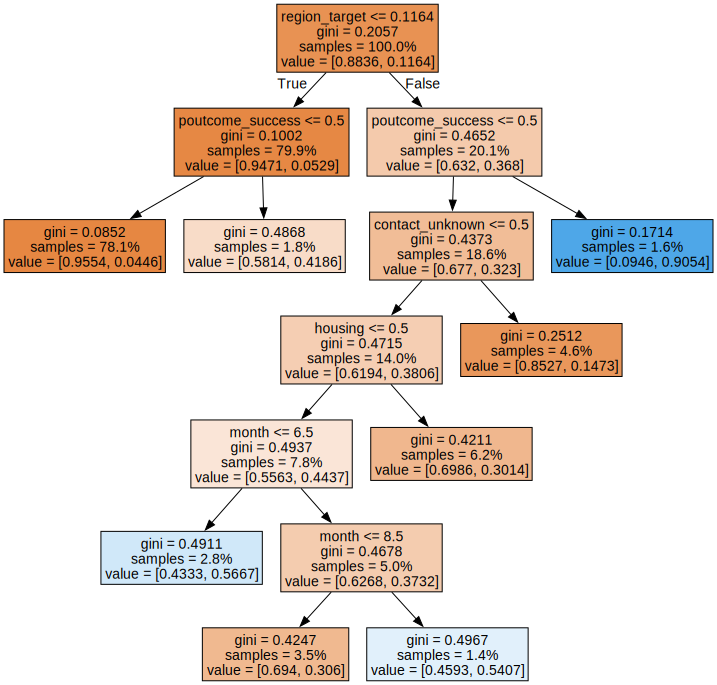

In [1049]:
dot_data = sklearn.tree.export_graphviz(
    target_v2_model, out_file=None, feature_names = target_v2_feature_names, filled = True, 
    proportion = True, precision=4, impurity = True)

graph = graphviz.Source(dot_data)
graph

In [1050]:
target_v2_model_def_df = get_model_definition(target_v2_model, target_v2_feature_names)

In [1051]:
target_v2_model_def_df

,total,conversion,converted_users,share_of_converted,share_of_total,cum_share_of_total,cum_share_of_converted
condition,,,,,,,
(region_target > 0.12) and (poutcome_success > 0.50),634,90.54,574,12.12,1.56,1.56,12.12
(region_target > 0.12) and (poutcome_success <= 0.50) and (month <= 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50),1154,56.67,654,13.81,2.84,4.39,25.93
(region_target > 0.12) and (poutcome_success <= 0.50) and (month > 8.50) and (housing <= 0.50) and (contact_unknown <= 0.50),577,54.07,312,6.59,1.42,5.81,32.52
(region_target <= 0.12) and (poutcome_success > 0.50),719,41.86,301,6.36,1.77,7.58,38.88
(region_target > 0.12) and (poutcome_success <= 0.50) and (month > 6.50) and (month <= 8.50) and (housing <= 0.50) and (contact_unknown <= 0.50),1438,30.60,440,9.29,3.53,11.11,48.17
(region_target > 0.12) and (poutcome_success <= 0.50) and (housing > 0.50) and (contact_unknown <= 0.50),2528,30.14,762,16.09,6.21,17.33,64.27
(region_target > 0.12) and (poutcome_success <= 0.50) and (contact_unknown > 0.50),1867,14.73,275,5.81,4.59,21.92,70.07
(region_target <= 0.12) and (poutcome_success <= 0.50),31772,4.46,1417,29.93,78.08,100.00,100.00


In [1052]:
region_encoding_df[region_encoding_df.region_target > 0.1173]

,region,region_count,raw_region_target,smoothing,region_target
37,Bristol,995,0.38,1.00,0.38
110,Leicester,774,0.37,1.00,0.37
113,Liverpool,1826,0.35,1.00,0.35
119,Manchester,3857,0.37,1.00,0.37
128,Newcastle,632,0.40,1.00,0.40


In [1056]:
target_v2_selected_df = test_df[
    ((test_df.region_target > 0.12) & (test_df.poutcome_success > 0.50)) | 
    ((test_df.region_target > 0.12) & (test_df.poutcome_success <= 0.50) & (test_df.month <= 6.50) & (test_df.housing <= 0.50) & (test_df.contact_unknown <= 0.50)) | 
    ((test_df.region_target > 0.12) & (test_df.poutcome_success <= 0.50) & (test_df.month > 8.50) & (test_df.housing <= 0.50) 
         & (test_df.contact_unknown <= 0.50)) | 
    ((test_df.region_target <= 0.12) & (test_df.poutcome_success > 0.50)	) | 
    ((test_df.region_target > 0.12) & (test_df.poutcome_success <= 0.50) & (test_df.month > 6.50) & (test_df.month <= 8.50) 
         & (test_df.housing <= 0.50) & (test_df.contact_unknown <= 0.50)	)
]

target_v2_selected_df.shape[0], target_v2_selected_df.y.sum()

(500, 247)